To keep it as simple as possible, this first tutorial uses synthetic data. This gives the possibility to change the signal shape at will. It also avoids downloading and de-trending real data.

We use the batman-package [(Kreidberg 2015)](http://adsabs.harvard.edu/abs/2015PASP..127.1161K) to generate a planet around a solar-like star with a period of ~10 days. The dataset is 100 days long at a cadence of 30min (as with Kepler LC). We add 50ppm white noise per cadence.

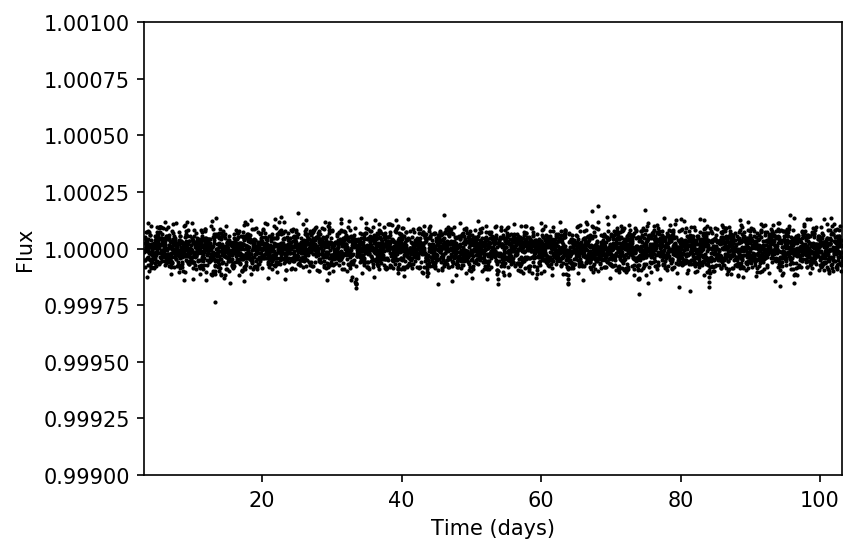

In [2]:
import numpy
import batman
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.dpi"] = 150

numpy.random.seed(seed=0)  # reproducibility 

# Create test data
time_start = 3.14
data_duration = 100
samples_per_day = 48
samples = int(data_duration * samples_per_day)
time = numpy.linspace(time_start, time_start + data_duration, samples)

# Use batman to create transits
ma = batman.TransitParams()
ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
ma.per = 10.123  # orbital period
ma.rp = 6371 / 696342  # 6371 planet radius (in units of stellar radii)
ma.a = 19  # semi-major axis (in units of stellar radii)
ma.inc = 90  # orbital inclination (in degrees)
ma.ecc = 0  # eccentricity
ma.w = 90  # longitude of periastron (in degrees)
ma.u = [0.4, 0.4]  # limb darkening coefficients
ma.limb_dark = "quadratic"  # limb darkening model
m = batman.TransitModel(ma, time)  # initializes model
synthetic_signal = m.light_curve(ma)  # calculates light curve

# Create noise and merge with flux
ppm = 50  # Noise level in parts per million
noise = numpy.random.normal(0, 10**-6 * ppm, int(samples))
flux = synthetic_signal + noise

# Plot raw data
plt.figure()
ax = plt.gca()
ax.scatter(time, flux, color='black', s=1)
ax.set_ylabel("Flux")
ax.set_xlabel("Time (days)")
plt.xlim(min(time), max(time))
plt.ylim(0.999, 1.001);

The transits are visually nearly invisible. 
Now, we run TLS without priors. These 3 lines of code is really all it takes to get started:

In [3]:
from transitleastsquares import transitleastsquares
model = transitleastsquares(time, flux)
results = model.power()

Transit Least Squares TLS 1.0.16 (29 January 2019)
Creating model cache for 37 durations
Searching 4800 data points, 10870 periods from 0.602 to 50.0 days
Using all 8 CPU threads


100%|██████████| 10870/10870 periods | 00:09<00:00


To see the results, we print some statistics:

In [4]:
print('Period', format(results.period, '.5f'), 'd')
print(len(results.transit_times), 'transit times in time series:', \
        ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Transit depth', format(results.depth, '.5f'))
print('Best duration (days)', format(results.duration, '.5f'))
print('Signal detection efficiency (SDE):', results.SDE)

Period 10.12473 d
9 transit times in time series: ['13.25629', '23.38102', '33.50575', '43.63048', '53.75521', '63.87994', '74.00467', '84.12940', '94.25413']
Transit depth 0.99990
Best duration (days) 0.18443
Signal detection efficiency (SDE): 27.077678397195708


And visualize the result:

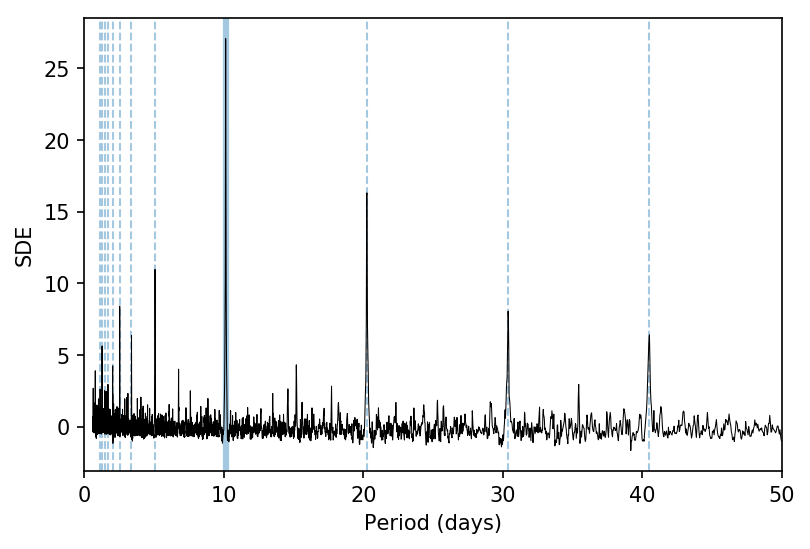

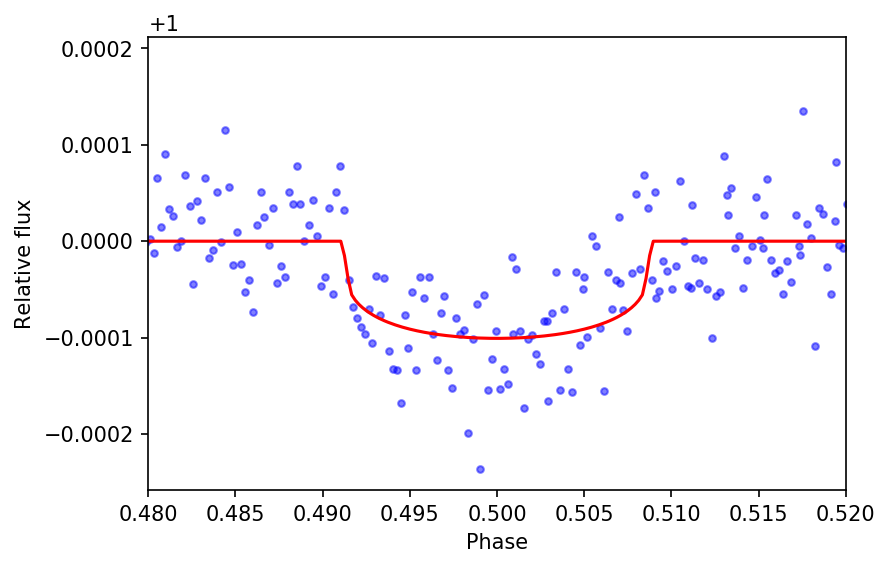

In [5]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods))

plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.48, 0.52)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

That's it! Now you can start to make your own tests.